In [1]:
%pip install category_encoders
%pip install sklearn-gbmi
%pip install pdpbox
%pip install pycebox
%pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython

     |████████████████████████████████| 80 kB 699 kB/s eta 0:00:011
  Using cached scipy-1.4.1-cp37-cp37m-manylinux1_x86_64.whl (26.1 MB)
  Using cached scikit_learn-0.22.1-cp37-cp37m-manylinux1_x86_64.whl (7.0 MB)
  Using cached pandas-0.25.3-cp37-cp37m-manylinux1_x86_64.whl (10.4 MB)
  Using cached numpy-1.19.1-cp37-cp37m-manylinux2010_x86_64.whl (14.5 MB)
     |████████████████████████████████| 9.5 MB 1.1 kB/s eta 0:00:01
     |████████████████████████████████| 231 kB 22.6 MB/s eta 0:00:01
  Using cached joblib-0.16.0-py3-none-any.whl (300 kB)
  Using cached python_dateutil-2.8.1-py2.py3-none-any.whl (227 kB)
  Using cached pytz-2020.1-py2.py3-none-any.whl (510 kB)
  Using cached six-1.15.0-py2.py3-none-any.whl (10 kB)
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver befor

In [129]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import pandas as pd
import category_encoders as ce
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence
from sklearn_gbmi import *
import operator
import pdpbox
from pdpbox import pdp
from pycebox.ice import ice, ice_plot
import statsmodels.api as sm
import scipy.stats as stats
from alepython import ale_plot
from collections import defaultdict

%matplotlib inline

# Задание: в рамках предложенного датасета, понять, как и какие фичи  влияют на таргет. Для этого предлагается построить линейную регрессию (glass box подход) и использовать градиентный бустинг + vi, pdp, ice (black box подход).

In [146]:
data  = pd.read_csv(
        "ML2/sample_set_filtered.csv",
        header=None,
        sep=',',
        quotechar='\"',
        error_bad_lines=False)
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1,4.5,Красноярск,Гимназия,0.70,5.0,0.0,300,2.0,1,1,58,19
1,0,5.0,Киров,СОШ,0.00,-1.0,0.0,70,4.2,2,1,61,19
2,1,3.0,СПб,Лицей,0.09,4.0,1.0,300,7.0,1,1,57,12
3,1,4.0,СПб,Лицей,0.30,3.0,30.0,80,5.5,4,1,56,15
4,0,5.0,СПб,Гимназия,0.05,5.0,0.0,60,2.5,2,1,61,17


In [147]:
# There are many unique cities, it will be an obvious overfitting.
# Feature 10 is constant.
data = data.drop([2, 10], axis=1)
y = data[12]
data = pd.get_dummies(data)
X = data.drop([12], axis=1)
X_scaled = MinMaxScaler().fit_transform(X)
lin_reg = LinearRegression().fit(X_scaled, y)
print(f'Regression score is {lin_reg.score(X_scaled, y)}')
X.head()

Regression score is 0.27096853435260837


,0,1,4,5,6,7,8,9,11,3_Гимназия,3_Лицей,3_СОШ
0,1,4.5,0.70,5.0,0.0,300,2.0,1,58,1,0,0
1,0,5.0,0.00,-1.0,0.0,70,4.2,2,61,0,0,1
2,1,3.0,0.09,4.0,1.0,300,7.0,1,57,0,1,0
3,1,4.0,0.30,3.0,30.0,80,5.5,4,56,0,1,0
4,0,5.0,0.05,5.0,0.0,60,2.5,2,61,1,0,0


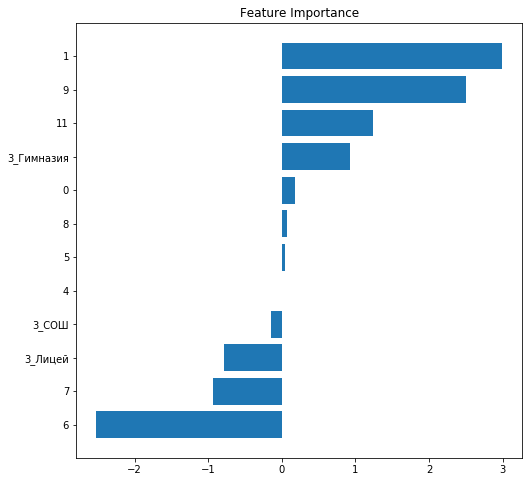

In [150]:
feature_importance = lin_reg.coef_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(8, 8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()

In [152]:
gb = GradientBoostingRegressor().fit(X, y)
print(f'Gradient boosting score is {gb.score(X, y)}')

Gradient boosting score is 0.9996385236347396


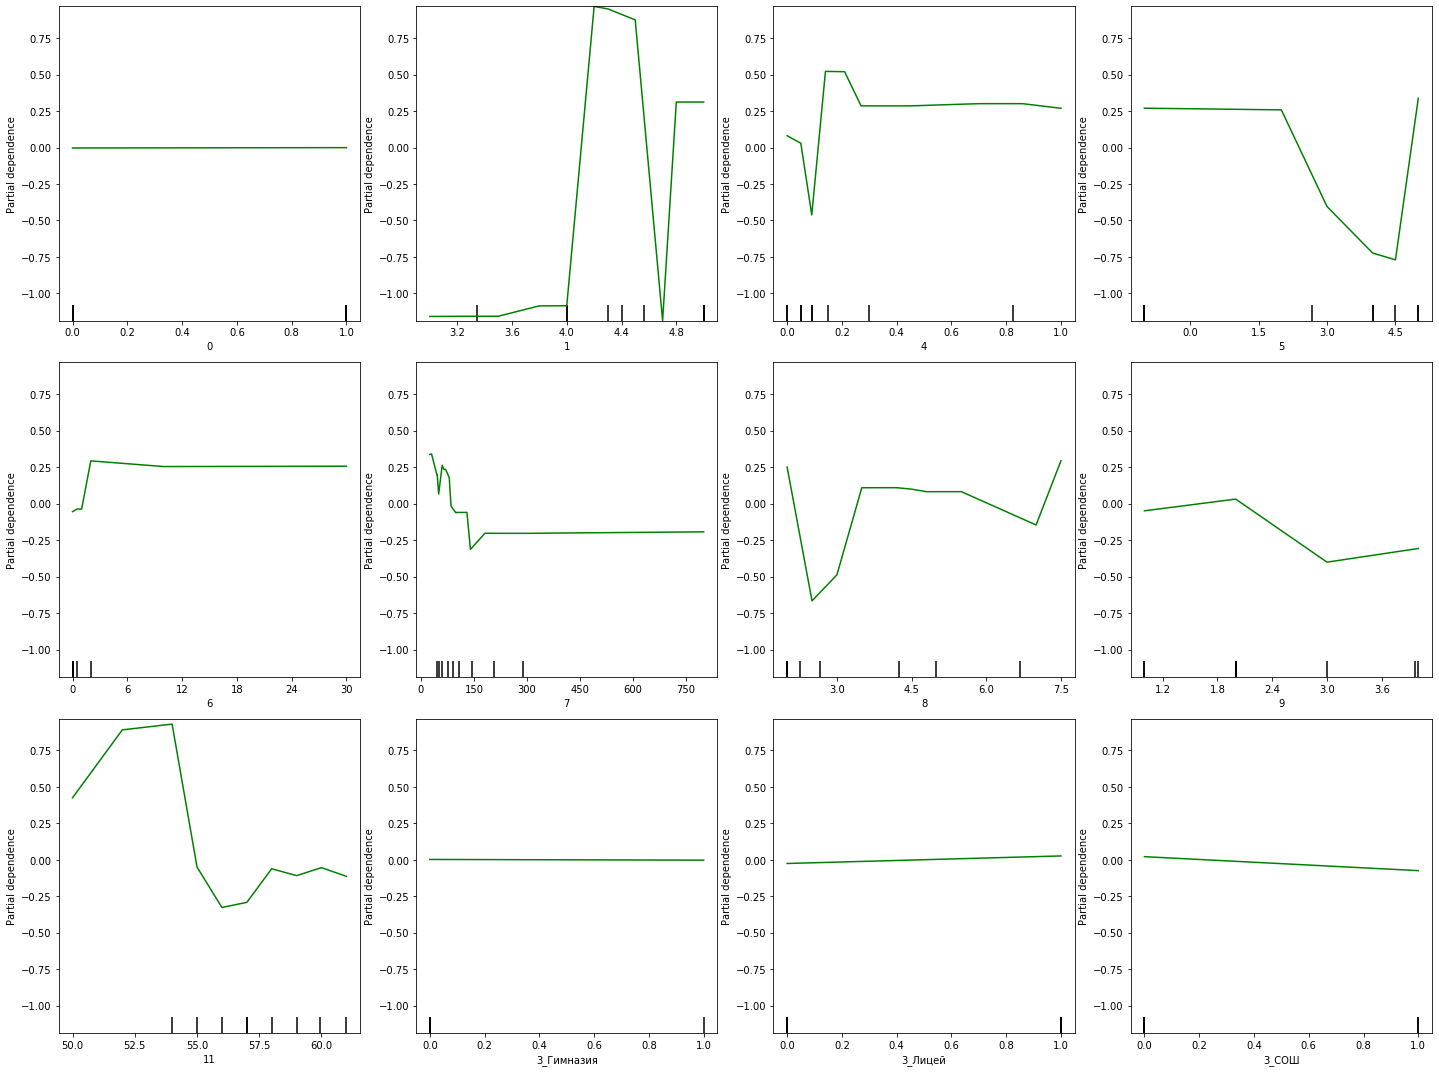

In [153]:
fig, ax = plot_partial_dependence(gb, X, features=range(len(X.columns)), feature_names=X.columns, n_cols=4)
fig.set_figwidth(20)
fig.set_figheight(15)
fig.tight_layout() 

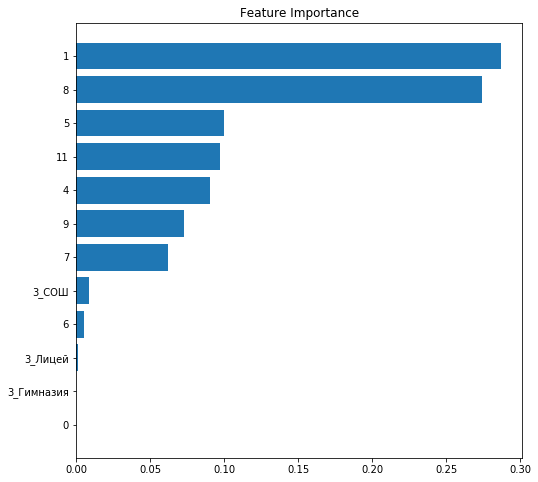

In [154]:
feature_importance = gb.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(8, 8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()

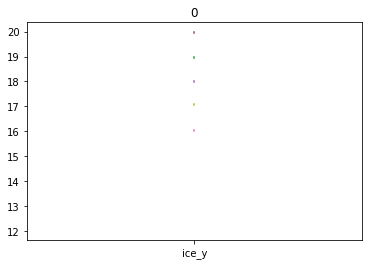

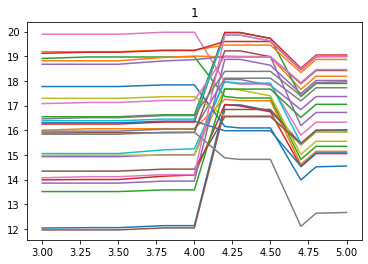

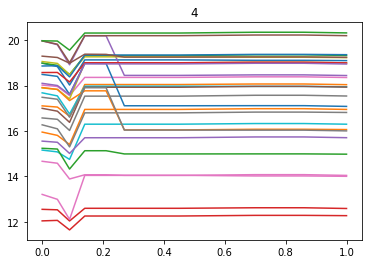

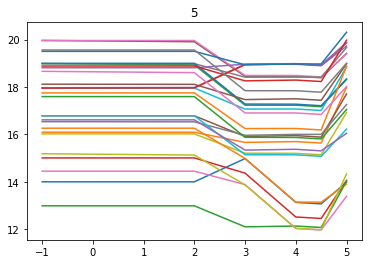

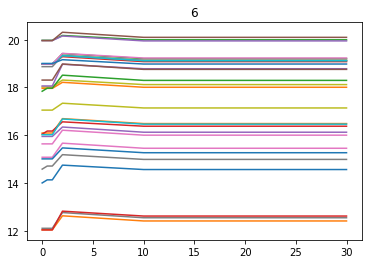

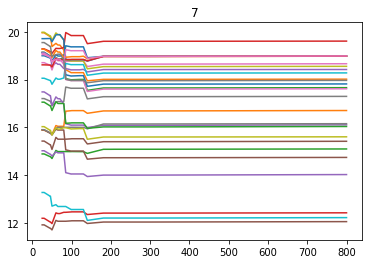

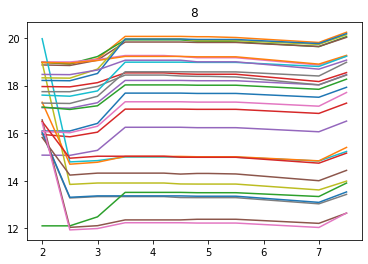

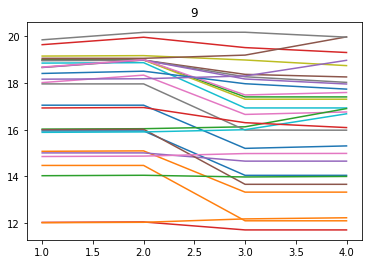

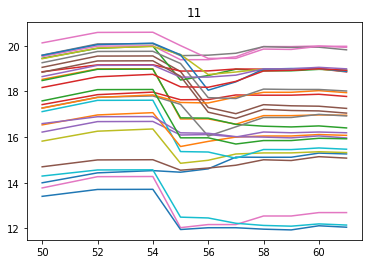

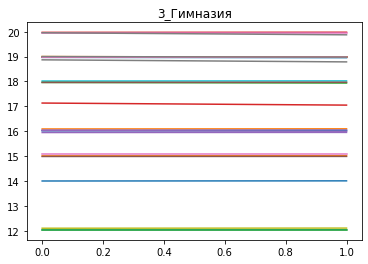

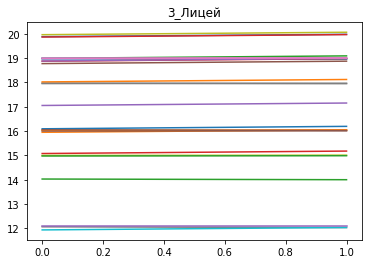

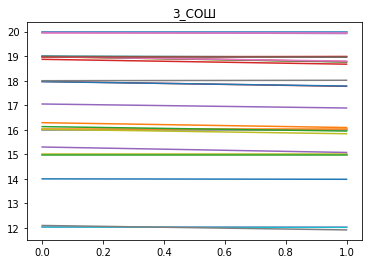

In [110]:
for name in X.columns:
    ice_data = ice(X, column=name, predict=gb.predict)
    a = ice_plot(ice_data)
    a.set_title(name)

Linear model features with biggest coefs are: **1**, **9**, **11**, ~~6~~, **7**.

Boosting best features are: **1**, **8**, **5**, **11**, ~~4~~.

I believe that features 1 and 11 should be important in the resulting model. Their distributions are nice and 1 most probably gives an average grade or smth.

6 is a weird feature because has many zeros.

8 is reasonable. I like ICE for 8.

Plots for 4 are weired, there is a dip which looks like overfitting.

5 looks like a good feature, though many values are not present and replaced with -1. 

7 and 9 both look reasonable.

All in all, good better features are 1, 5, 7, 8, 9, 11.

In [177]:
# Fit regression only for best features. Here I removed 5 and 7 with a small decline in score.

X_best = X[[1, 8, 9, 11]]
X_scaled = MinMaxScaler().fit_transform(X_best)
lin_reg = LinearRegression().fit(X_scaled, y)
print(f'Regression score is {lin_reg.score(X_scaled, y)}')

Regression score is 0.19326360133411735


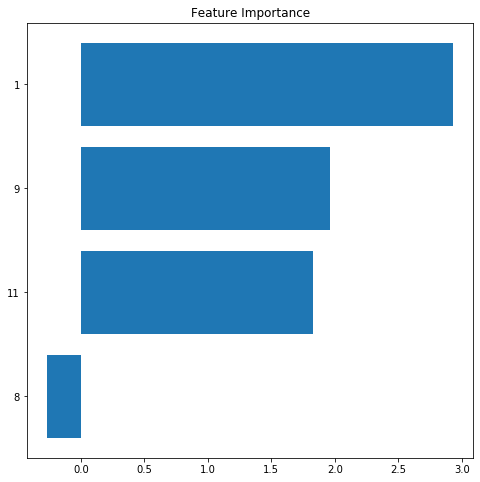

In [178]:
feature_importance = lin_reg.coef_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(8, 8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X_best.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()